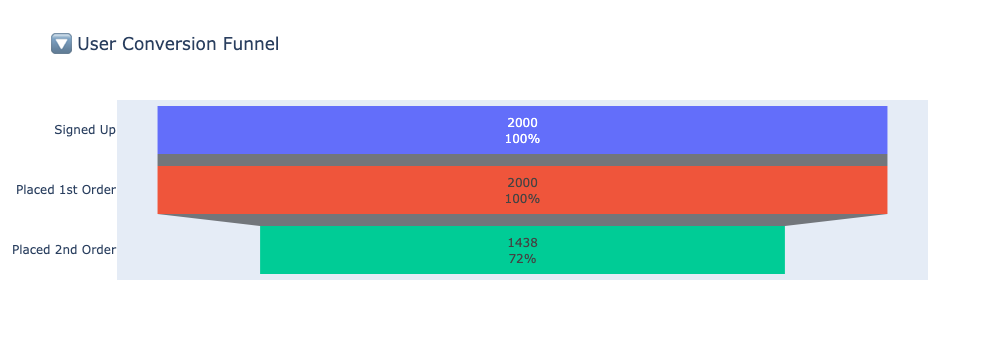

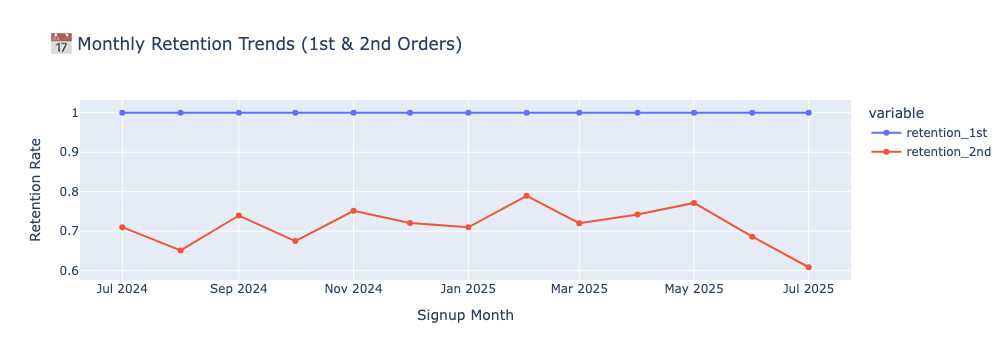

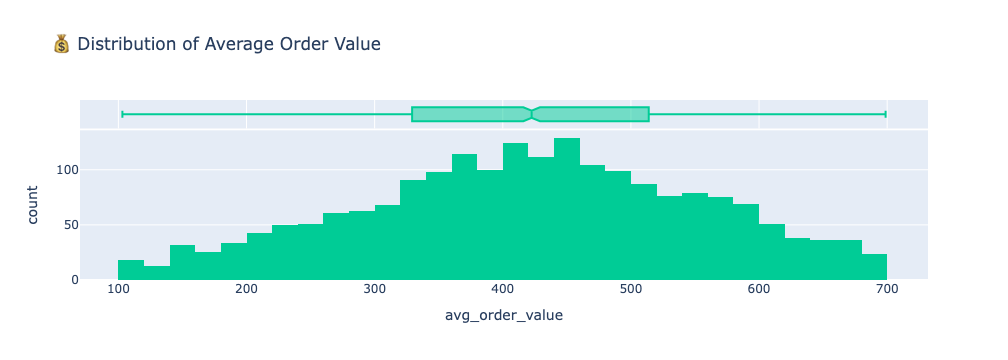

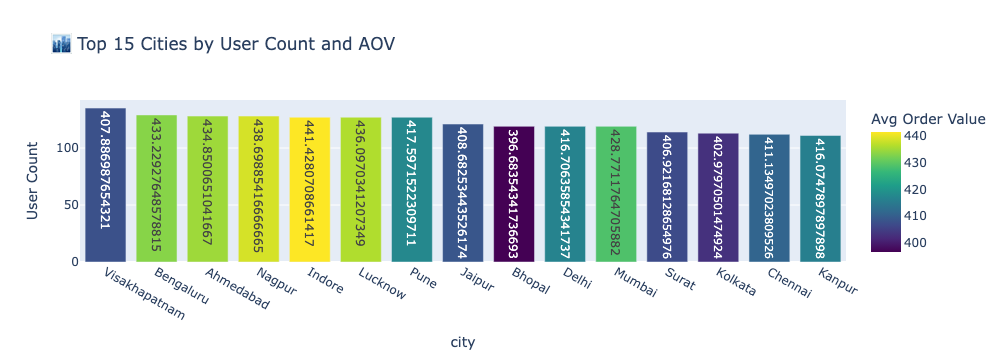

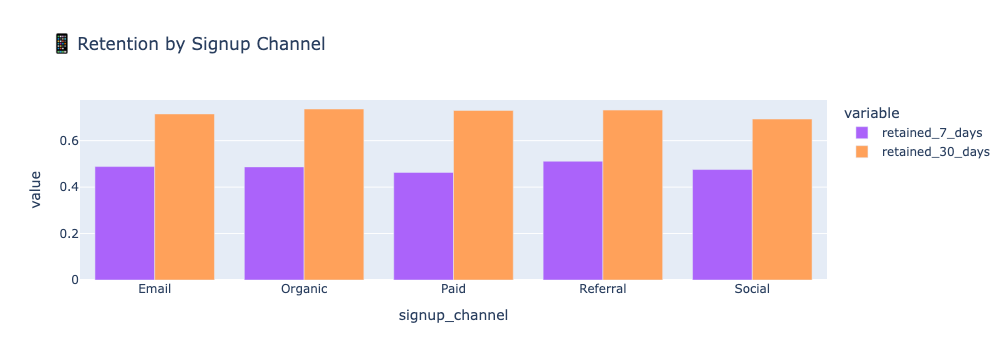

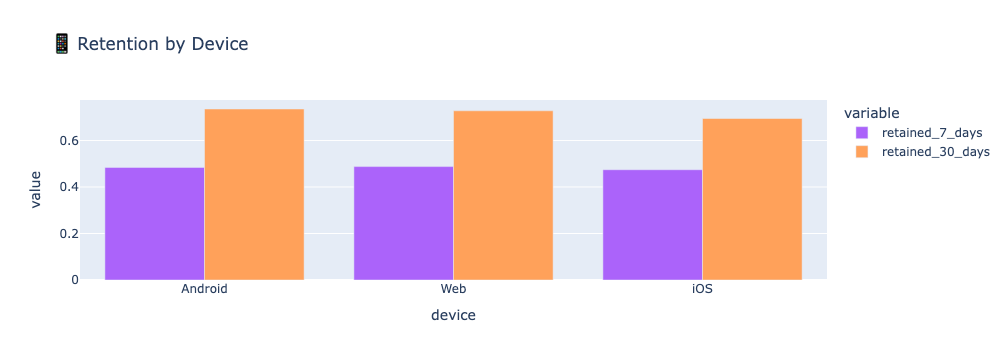

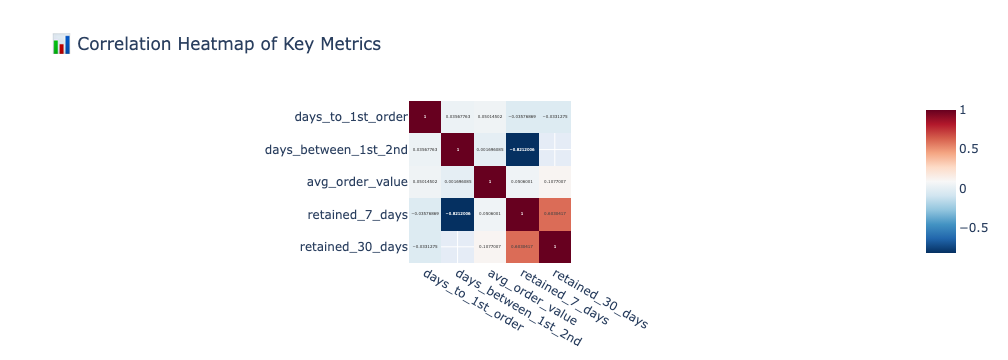

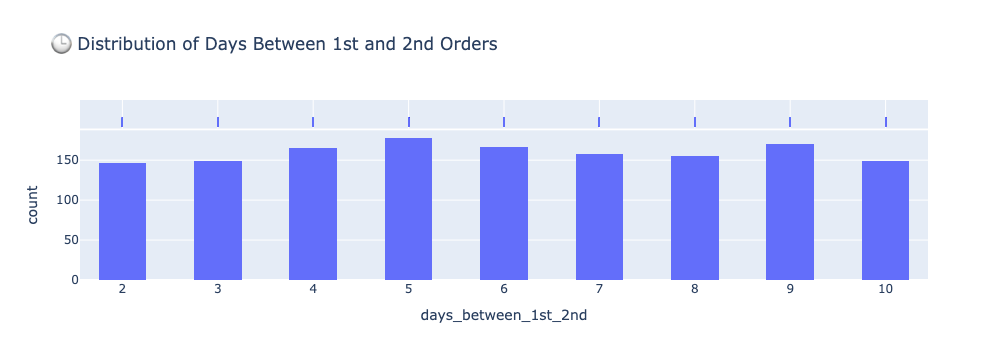

🧯 Churn after 1st order: 28.10%


In [11]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Load data
df = pd.read_csv("swiggy_user_orders_dataset.csv")

# -----------------------------
# 🛠️ Date Parsing & Engineering
# -----------------------------
date_cols = ['signup_date', 'first_order_date', 'second_order_date', 'third_order_date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

df['days_to_1st_order'] = (df['first_order_date'] - df['signup_date']).dt.days
df['days_between_1st_2nd'] = (df['second_order_date'] - df['first_order_date']).dt.days
df['days_between_2nd_3rd'] = (df['third_order_date'] - df['second_order_date']).dt.days
df['total_orders'] = df[['first_order_date', 'second_order_date', 'third_order_date']].notnull().sum(axis=1)
df['avg_order_value'] = df[['order_value_1', 'order_value_2', 'order_value_3']].mean(axis=1)
df['signup_month'] = df['signup_date'].dt.to_period('M').astype(str)

# ---------------------------------
# 🔽 Funnel Chart: Conversion Stages
# ---------------------------------
signup_total = df.shape[0]
first_orders = df['first_order_date'].notna().sum()
second_orders = df['second_order_date'].notna().sum()

fig_funnel = go.Figure(go.Funnel(
    y=["Signed Up", "Placed 1st Order", "Placed 2nd Order"],
    x=[signup_total, first_orders, second_orders],
    textposition="inside", textinfo="value+percent previous",
    marker=dict(color=["#636EFA", "#EF553B", "#00CC96"])
))
fig_funnel.update_layout(title="🔽 User Conversion Funnel")
fig_funnel.show()

# ----------------------------------------
# 📈 Retention Rate Over Signup Cohorts
# ----------------------------------------
monthly_ret = df.groupby('signup_month').agg(
    total_signups=('user_id', 'count'),
    first_orders=('first_order_date', lambda x: x.notna().sum()),
    second_orders=('second_order_date', lambda x: x.notna().sum())
).reset_index()

monthly_ret['retention_1st'] = monthly_ret['first_orders'] / monthly_ret['total_signups']
monthly_ret['retention_2nd'] = monthly_ret['second_orders'] / monthly_ret['total_signups']

fig_retention = px.line(
    monthly_ret,
    x='signup_month',
    y=['retention_1st', 'retention_2nd'],
    title="📅 Monthly Retention Trends (1st & 2nd Orders)",
    markers=True,
    labels={"value": "Retention Rate", "signup_month": "Signup Month"},
    color_discrete_map={'retention_1st': '#636EFA', 'retention_2nd': '#EF553B'}
)
fig_retention.show()

# -----------------------------------------------
# 🧊 Average Order Value Distribution & Outliers
# -----------------------------------------------
fig_aov = px.histogram(
    df, x="avg_order_value", nbins=40,
    marginal="box", title="💰 Distribution of Average Order Value",
    color_discrete_sequence=["#00CC96"]
)
fig_aov.show()

# ---------------------------------------------------
# 🏙️ Top Cities by User Count and Avg Order Value
# ---------------------------------------------------
city_stats = df.groupby('city').agg(
    user_count=('user_id', 'count'),
    avg_order_value=('avg_order_value', 'mean')
).sort_values('user_count', ascending=False).head(15).reset_index()

fig_city = px.bar(
    city_stats, x='city', y='user_count',
    text='avg_order_value', color='avg_order_value',
    title="🏙️ Top 15 Cities by User Count and AOV",
    labels={'user_count': 'User Count', 'avg_order_value': 'Avg Order Value'},
    color_continuous_scale='Viridis'
)
fig_city.show()

# -----------------------------------------
# 🔍 Retention by Signup Channel & Device
# -----------------------------------------
for attr in ['signup_channel', 'device']:
    attr_ret = df.groupby(attr)[['retained_7_days', 'retained_30_days']].mean().reset_index()
    fig_attr = px.bar(
        attr_ret, x=attr,
        y=['retained_7_days', 'retained_30_days'],
        barmode="group",
        title=f"📱 Retention by {attr.replace('_', ' ').title()}",
        color_discrete_map={'retained_7_days': '#AB63FA', 'retained_30_days': '#FFA15A'}
    )
    fig_attr.show()

# ------------------------------------
# 🧮 Correlation Between Key Features
# ------------------------------------
corr_cols = ['days_to_1st_order', 'days_between_1st_2nd', 'avg_order_value', 'retained_7_days', 'retained_30_days']
fig_corr = px.imshow(
    df[corr_cols].corr(), text_auto=True,
    title="📊 Correlation Heatmap of Key Metrics",
    color_continuous_scale="RdBu_r"
)
fig_corr.show()

# ----------------------------------------------------------
# ⏱️ Time to First Order vs 30-Day Retention (Trendline)
# ----------------------------------------------------------
import pandas as pd
import numpy as np
import plotly.express as px

# --- Sample DataFrame creation (replace with your actual DataFrame) ---
# df = pd.read_csv("your_data.csv")  # If loading from a CSV

# Ensure correct data types
df['days_to_1st_order'] = pd.to_numeric(df['days_to_1st_order'], errors='coerce')
df['retained_30_days'] = pd.to_numeric(df['retained_30_days'], errors='coerce')

# Drop rows with NaNs in either of the relevant columns
scatter_data = df[['days_to_1st_order', 'retained_30_days']].dropna()

# ---------------------------------------------------
# 🔁 Reorder Delays Distribution (1st to 2nd Order)
# ---------------------------------------------------
fig_reorder_delay = px.histogram(
    df[df['days_between_1st_2nd'].notna()],
    x="days_between_1st_2nd", nbins=40, marginal="rug",
    title="🕒 Distribution of Days Between 1st and 2nd Orders",
    color_discrete_sequence=["#636EFA"]
)
fig_reorder_delay.show()

# ---------------------------------------------------
# 📉 Churn Rate = Users who didn't order again
# ---------------------------------------------------
df['churned_after_1st'] = df['second_order_date'].isna()
churn_rate = df['churned_after_1st'].mean()

print(f"🧯 Churn after 1st order: {churn_rate:.2%}")
